<a href="https://colab.research.google.com/github/jdbioinf/Deep_Learning_Study/blob/main/FoodVisionEffNetB2_app_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food101 🤗 App Using EfficientNetB2 Transfer Learning

This notebook contains a python script for using the EfficientNetB2 feature extractor architecture trained on the Food101 dataset for classification of images of food. The model is also deployed to Hugging Face

Description of the Food101 dataset (from [PyTorch Food101 documentation](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html)):
- The Food-101 is a challenging data set of 101 food categories with 101,000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images.
- On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels.
- All images were rescaled to have a maximum side length of 512 pixels.

Description of EfficientNetB2 (from [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)):
- **Abstract** - EfficientNet-B7 achieves state-of-the-art 84.3% top-1 accuracy on ImageNet, while being 8.4x smaller and 6.1x faster on inference than the best existing ConvNet.
- **Introduction** - Scaling up CNNs improves accuracy, and is usually achieved by increasing depth (layers) or width (hidden units). Sometimes scaling up is also achieved by increasing image resolution. EffNet aims to scale up CNNs efficiently by uniformly increasing width, depth and resolution with a constant ratio (compound scaling method). E.g. if we use 2^N times more computational resources, then we can increase the network depth by α^N , width by β^N , and image size by γ^N , where α, β, γ are constant coefficients determined by a small [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) on the original small model.
- **Compound Scaling Method** - EfficientNet use a compound coefficient φ to uniformly scale network width, depth, and resolution:


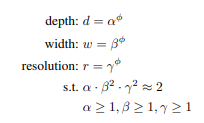
  
  
  - φ is user-specific coefficient that controls how much more resources are available for scaling while  α, β, γ specify how to assign these extra resources to network width, depth, and resolution respectively. This results in a much lower increase in [FLOPS](https://stackoverflow.com/questions/58498651/what-is-flops-in-field-of-deep-learning) (floating point operations per second) than other CNNs.
-**EfficientNet Architecture** - EfficientNet is a baseline mobile-size model for use to demonstrate the efficiency of the compound scaling method, and is based on similar architecture to that used by the [MnasNet CNN](https://arxiv.org/abs/1807.11626).

  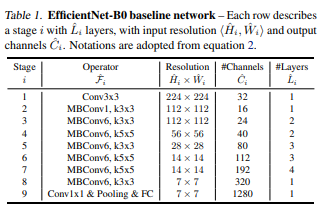
  
  Starting from the baseline EfficientnetB0, the compound scaling method is used to scale up depth, width and resolution in two steps:
  - STEP 1: fix φ = 1, assuming twice more resources available, and do a small grid search of α, β - which identifies the best values for EfficientNet-B0 are α = 1.2, β = 1.1, γ = 1.15, under constraint of α · β^2· γ^2 ≈ 2
  - STEP 2: we then fix α, β, γ as constants and scale up baseline network with different φ using Equation 3, to obtain EfficientNet-B1 to B7

- **Transfer Learning** - EfficientNet was tested on several datasets to assess its applicability for transfer learning, including Food-101. Generally, the various scaled versions of EfficientNet achieve improved accuracies compared to other deep learning models such as ResNet-50 (all models were fine-tuned for each dataset tested):
  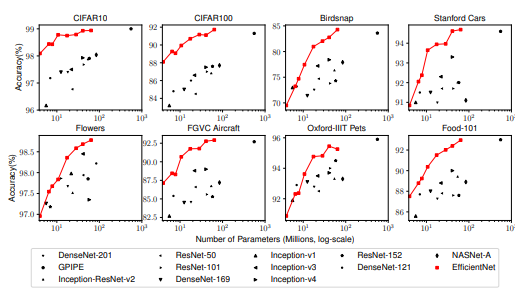


For this app, EfficientNet-B2 will be used. EfficientNetB2 contains 9.2M parameters.

### Model Notes:
Much of the code below could be converted to functions and/or modules to be imported. However, in this case this is mostly not done in order to demonstrate all code within a single script that can be easily referenced.

Due to GPU limitations for free Google Colab, I only show the training for the final dataset below. Previously, the model was tested using the following setups:
- 10% of the Food101 dataset for 2 epochs of training (inital test to check for errors in code) - 48.4% Test Accuracy
- 10% of the Food101 dataset for 5 epochs of training - 55.2% Test Accuracy (marginal accuracy improvement - retry with more data)
- 30% of the Food101 dataset for 5 epochs of training - 61.37% Accuracy (another marginal accuracy improvement - retry with more data and more epochs)

These tests demonstrated that additional epochs and more data could improve accuracy. **In the final model shown below, 50% of the Food101 dataset is used, with 10 epochs of training. The final model accuracy for the test set was 63.9%**. This is still only a small improvement on the 30% dataset with 5 epochs of training. Better training may be achieved using more data for more epochs, or by using a different transfer learning model (such as ViT) that includes more parameters and therefore more learning opportunities. The EffNetB2 model could also be fine-tuned for the Food101 dataset (as it was during testing on the Food-101 dataset in the EfficientNet paper).

Additional epochs or more data would probably use more compute resources than is available in a free Google Colab session. Therefore the 50% Food101 dataset trained for 10 epochs is used for the app.

Note: the loss curve test accuracy converges at approximately 65% despite increases in train accuracy, so including more epochs is unlikely to significantly increase test accuracy.

As per the Bitter Lesson (http://www.incompleteideas.net/IncIdeas/BitterLesson.html), more data and more parameters will increase model accuracy. However, we will be limited by compute resources and time.

"...breakthrough progress eventually arrives by an opposing approach based on scaling computation by search and learning..." - Rich Sutton, 2019

In [1]:
!nvidia-smi

Mon Feb 26 18:52:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Set up Python environment
# Ensure PyTorch version 2+ and torchvision installation
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) == 1, "torch version should be 2+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

# Other required modules
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets
import os
from pathlib import Path
from tqdm import tqdm
from datetime import datetime

# Simplify some function names
from torch import nn
from torchvision import transforms as transforms
from timeit import default_timer as timer

# Attempt torchinfo import, install and import if first attempt fails
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Import the going_modular directory from PyTorch deep-learning course git repo, clone repo is import fails
# try:
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves

# Set up device agnostic code to run on either CPU or GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
torch.set_default_device(device)
print(f"Device is: {device}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121
Device is: cuda


## Set Hyperparameters

In [3]:
# Hyperparameters
SEED = 10
BATCH_SIZE = 64
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4
SUBSET_PERCENT = 0.5
EPOCHS = 10
print(f"Using {NUM_WORKERS} workers")
torch.manual_seed(SEED)

Using 2 workers


## Build EfficientNetB2 Model, Add Data Augmentation, Set Classifier Head

In [4]:
# Create EffNetB2 using pretrained weights, transforms and model (transfer learning)
EffNetB2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # use default (best) weights
EffNetB2_transforms_raw = EffNetB2_weights.transforms()
EffNetB2_model = torchvision.models.efficientnet_b2(weights=EffNetB2_weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 83.8MB/s]


In [5]:
# Use data augmentation for the training step, but not the test step
print(f"Raw transforms for EffNetB2: {EffNetB2_transforms_raw}")
EffNetB2_transforms_augmented = transforms.Compose([
    transforms.TrivialAugmentWide(31),
    EffNetB2_transforms_raw
])
print(f"Augmented transforms for EffNetB2: {EffNetB2_transforms_augmented}")

Raw transforms for EffNetB2: ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
Augmented transforms for EffNetB2: Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)


In [6]:
# Summary of EffNetB2 using torchinfo summary
summary(EffNetB2_model,
        input_size=(1, 3, 224, 224), # example batch of images with 3 colour channels from Food101
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [7]:
# Prevent base layers from training to perform feature extraction without fine-tuning
for param in EffNetB2_model.parameters():
    param.requires_grad = False

In [8]:
# Summary of EffNetB2 using torchinfo summary
summary(EffNetB2_model,
        input_size=(1, 3, 224, 224), # example batch of images with 3 colour channels from Food101
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [9]:
# Change classifier head shape to 101 outputs not 1000
print("Original classififer head shape:\n", EffNetB2_model.classifier)
EffNetB2_model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=101, bias=True)
)
print("New classifier head shape for Food101\n", EffNetB2_model.classifier)

Original classififer head shape:
 Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)
New classifier head shape for Food101
 Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=101, bias=True)
)


In [10]:
# Summary of EffNetB2 using torchinfo summary
summary(EffNetB2_model,
        input_size=(1, 3, 224, 224), # example batch of images with 3 colour channels from Food101
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [11]:
# # Compile model to allow operator fusion for faster training
# EffNetB2_model = torch.compile(EffNetB2_model).to(device)
# # Summary of EffNetB2 using torchinfo summary
# summary(EffNetB2_model,
#         input_size=(1, 3, 224, 224), # example batch of images with 3 colour channels from Food101
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

## Set Up FoodVisionBig Dataset (50% Of Images)

In [12]:
def subset_dataset(dataset: torchvision.datasets, percent: float = 0.1, seed: int = 10, device = None) -> tuple:
  """Extracts a random subset of a torch.utils.data.datasets.
  Returns a tuple that contains the selected subset and the non-selected subset"""
  generator = torch.cuda.manual_seed(seed) if ("cuda" in str(device)) else torch.manual_seed(seed)
  #print(generator)
  extraction_size = int(percent*len(dataset))
  extraction1, extraction2 = torch.utils.data.random_split(dataset=dataset, lengths=[extraction_size, len(dataset) - extraction_size],
                                                          generator=generator)
  return extraction1, extraction2

In [13]:
# Download PyTorch Food101 images, create dataset objects and subset 50% of the datasets, not sure if this uses operator fusion to create DataLoader objects
data_dir = Path("data")

train_dataloader = torch.utils.data.DataLoader(subset_dataset(dataset=datasets.Food101(root=data_dir,
                                                                               split="train",
                                                                               transform=EffNetB2_transforms_augmented,
                                                                               download=True
                                                                               ),percent=SUBSET_PERCENT,device=device)[0],
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         #pin_memory=True,
                                         generator=torch.Generator(device=device) # prevent device error when iterating over DataLoader with gpu
                                         )
test_dataloader = torch.utils.data.DataLoader(subset_dataset(dataset=datasets.Food101(root=data_dir,
                                                                              split="test",
                                                                              transform=EffNetB2_transforms_raw,
                                                                              download=True
                                                                              ),percent=SUBSET_PERCENT,device=device)[0],
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         #pin_memory=True,
                                         generator=torch.Generator(device=device)
                                         )
class_names = datasets.Food101(root=data_dir,
                              split="train",
                              download=False
                              ).classes
print(class_names[:10])
print(f"Number of train batches (size {BATCH_SIZE}): {len(train_dataloader)}")
print(f"Number of test batches (size {BATCH_SIZE}): {len(test_dataloader)}")

100%|██████████| 4996278331/4996278331 [04:49<00:00, 17273115.59it/s]


Extracting data/food-101.tar.gz to data
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']
Number of train batches (size 64): 592
Number of test batches (size 64): 198


## Train Model

Note on inference_mode() vs no_grad() in PyTorch 2:
- The main difference between the two is that inference_mode() is a more extreme version of no_grad(). In addition to disabling gradient computation, inference_mode() also disables view tracking and version counter bumps, which can result in even better performance.
- where possible, use inference_mode() but sometimes its will cause errors

In [14]:
# Train model for 10 epochs, test after each epoch

# Set loss function and optimiser
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1) # label smoothing normalisation to reduce overfitting with large number of classes
optimizer = torch.optim.Adam(params=EffNetB2_model.parameters(),betas=(0.9, 0.999),lr=0.001) # default arguments

def train_model(model: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_function: nn.Module,
                optimizer: torch.optim.Optimizer,
                epochs: int,
                device: torch.device,
                seed: int):
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  model.train()
  train_loss, train_acc = 0, 0 # initiate these statistics for training

  # Start train/test loop
  start_time = timer()
  train_time, test_time = 0, 0
  num_train_batches = len(train_dataloader)
  num_test_batches = len(test_dataloader)
  for epoch in tqdm(range(epochs)): # tqdm for progress bar :)

    # TRAINING #
    train_start = timer()
    for batch, (train_image, train_label) in enumerate(train_dataloader):
      train_image, train_label = train_image.to(device), train_label.to(device) # prevent device errors by moving data to target device
      train_pred_logits = model(train_image) # calculate prediction logits
      loss = loss_function(train_pred_logits, train_label) # calculate loss
      train_loss += loss.item() # accumulate loss to take average
      optimizer.zero_grad() # reset optimiser gradient
      loss.backward() # backpropogate loss
      optimizer.step() # perform weight optimisation
      y_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1) # get predicted class by index
      train_acc += (y_pred_class == train_label).sum().item()/len(y_pred_class) # accumulate accuracy metric at each batches to calculate average after iteration
      train_time += float(timer() - train_start)
    train_loss = train_loss / num_train_batches # calculate average loss across training batches
    train_acc = train_acc / num_train_batches # calculate average accuracy across training batches
    train_time = train_time / num_train_batches # calculate average time across training batches (average may be skewed by last batch as it may be small)

    # TESTING #
    model.eval() # turn off dropout and batch norm layers for testing
    test_loss, test_acc = 0, 0 # (re)-initiate at each epoch these statistics for testing
    test_start = timer()
    with torch.inference_mode():
      for batch, (test_image, test_label) in enumerate(test_dataloader):
        test_image, test_label = test_image.to(device), test_label.to(device)# prevent device errors by moving data to target device
        test_pred_logits = model(test_image) # calculate prediction logits
        loss = loss_function(test_pred_logits, test_label) # calculate loss
        test_loss += loss.item() # accumulate loss to take average
        y_pred_class = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1) # get predicted class by index
        test_acc += ((y_pred_class == test_label).sum().item()/len(y_pred_class)) # accumulate accuracy metric at each batches to calculate average after iteration
        test_time = float(timer() - test_start)
    test_loss = test_loss / num_test_batches # calculate average loss across testing batches
    test_acc = test_acc / num_test_batches # calculate average accuracy across testing batches
    test_time = test_time / num_test_batches # calculate average time across testing batches (average may be skewed by last batch as it may be small)
    print(f"[INFO] [{(timer() - start_time)}] EPOCH {epoch} - Loss (Train:Test) {train_loss:.2f}:{test_loss:.2f} | Accuracy (Train:Test) {(train_acc*100):.2f}:{(test_acc*100):.2f}")

  # Return dictionary of results
  return {"train_loss" : train_loss,
          "train_accuracy" : train_acc,
          "train_time" : train_time,
          "test_loss" : test_loss,
          "test_accuracy" : test_acc,
          "test_time" : test_time}

NOTE: Running the train_model cell below will take **2-3 hours** on a Tesla T4 GPU.

In [15]:
train_results_dict = train_model(model=EffNetB2_model,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                loss_function=loss_function,
                                optimizer=optimizer,
                                epochs=EPOCHS,
                                device=device,
                                seed=SEED)

 10%|█         | 1/10 [10:37<1:35:40, 637.78s/it]

[INFO] [637.7852893990001] EPOCH 0 - Loss (Train:Test) 3.33:2.43 | Accuracy (Train:Test) 35.20:55.87


 20%|██        | 2/10 [20:16<1:20:24, 603.05s/it]

[INFO] [1216.5213974950002] EPOCH 1 - Loss (Train:Test) 2.54:2.19 | Accuracy (Train:Test) 52.55:60.52


 30%|███       | 3/10 [29:45<1:08:31, 587.43s/it]

[INFO] [1785.3616964050002] EPOCH 2 - Loss (Train:Test) 2.36:2.12 | Accuracy (Train:Test) 56.97:62.49


 40%|████      | 4/10 [39:06<57:42, 577.03s/it]  

[INFO] [2346.4627468010003] EPOCH 3 - Loss (Train:Test) 2.26:2.10 | Accuracy (Train:Test) 59.77:62.91


 50%|█████     | 5/10 [48:26<47:34, 570.83s/it]

[INFO] [2906.2826794790003] EPOCH 4 - Loss (Train:Test) 2.19:2.08 | Accuracy (Train:Test) 61.47:63.43


 60%|██████    | 6/10 [57:44<37:45, 566.38s/it]

[INFO] [3464.03316505] EPOCH 5 - Loss (Train:Test) 2.14:2.08 | Accuracy (Train:Test) 63.25:63.30


 70%|███████   | 7/10 [1:07:16<28:25, 568.51s/it]

[INFO] [4036.936638395] EPOCH 6 - Loss (Train:Test) 2.10:2.07 | Accuracy (Train:Test) 64.79:63.56


 80%|████████  | 8/10 [1:16:45<18:57, 568.61s/it]

[INFO] [4605.764667281001] EPOCH 7 - Loss (Train:Test) 2.06:2.07 | Accuracy (Train:Test) 65.95:63.80


 90%|█████████ | 9/10 [1:26:13<09:28, 568.26s/it]

[INFO] [5173.23589397] EPOCH 8 - Loss (Train:Test) 2.03:2.07 | Accuracy (Train:Test) 67.03:63.80


100%|██████████| 10/10 [1:35:43<00:00, 574.38s/it]

[INFO] [5743.832064221] EPOCH 9 - Loss (Train:Test) 2.00:2.07 | Accuracy (Train:Test) 67.74:63.94


In [16]:
# # Train model for 10 epochs, test after each epoch
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# # Set loss function and optimiser
# loss_function = nn.CrossEntropyLoss(label_smoothing=0.1) # label smoothing normalisation to reduce overfitting with large number of classes
# optimizer = torch.optim.Adam(params=EffNetB2_model.parameters(),betas=(0.9, 0.999),lr=0.001) # default arguments

# EffNetB2_model.train()
# train_loss, train_acc = 0, 0 # initiate these statistics for training
# # train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=101).to(device)
# #prev_epoch_train_time, prev_epoch_test_time = timer(), timer()

# # Start train/test loop
# start_time = timer()
# for epoch in tqdm(range(EPOCHS)): # tqdm for progress bar :)

#   # TRAINING #
#   for batch, (train_image, train_label) in enumerate(train_dataloader):
#     train_image, train_label = train_image.to(device), train_label.to(device) # = train_image.to(device), train_label.to(device) # prevent device errors by moving data to target device
#     train_pred_logits = EffNetB2_model(train_image) # calculate prediction logits
#     loss = loss_function(train_pred_logits, train_label) # calculate loss
#     train_loss += loss.item() # accumulate loss to take average
#     optimizer.zero_grad() # reset optimiser gradient
#     loss.backward() # backpropogate loss
#     optimizer.step() # perform weight optimisation
#     y_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1) # get predicted class by index
#     train_acc += (y_pred_class == train_label).sum().item()/len(y_pred_class) # accumulate accuracy metric at each batches to calculate average after iteration
#   train_loss = train_loss / len(train_dataloader) # calculate average loss across training batches
#   train_acc = train_acc / len(train_dataloader) # calculate average accuracy across training batches
#   # train_accuracy.update(predicted_labels, train_label)

#   # TESTING #
#   EffNetB2_model.eval() # turn off dropout and batch norm layers for testing
#   test_loss, test_acc = 0, 0 # (re)-initiate at each epoch these statistics for testing
#   with torch.inference_mode():
#     for batch, (test_image, test_label) in enumerate(test_dataloader):
#       test_image, test_label = test_image.to(device), test_label.to(device)# prevent device errors by moving data to target device
#       test_pred_logits = EffNetB2_model(test_image) # calculate prediction logits
#       loss = loss_function(test_pred_logits, test_label) # calculate loss
#       test_loss += loss.item() # accumulate loss to take average
#       y_pred_class = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1) # get predicted class by index
#       test_acc += ((y_pred_class == test_label).sum().item()/len(y_pred_class)) # accumulate accuracy metric at each batches to calculate average after iteration
#   test_loss = test_loss / len(test_dataloader) # calculate average loss across testing batches
#   test_acc = test_acc / len(test_dataloader) # calculate average accuracy across testing batches
#   print(f"[INFO] [{(timer() - start_time)}] EPOCH {epoch} - Loss (Train:Test) {train_loss:.2f}:{test_loss:.2f} | Accuracy (Train:Test) {(train_acc*100):.2f}:{(test_acc*100):.2f}")

# Setting Up App Directory

Gradio app directory should have structure similar to this:
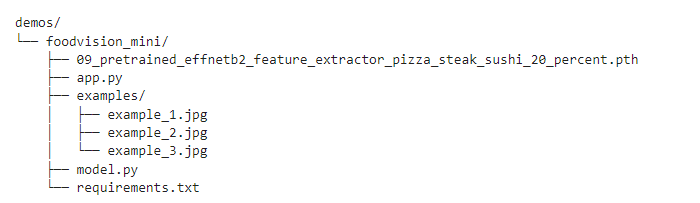

Also need to add class_names.txt file for the 101 class names

In [17]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.6 MB/s eta 0:00:00
Gradio version: 4.19.2


In [18]:
# Create target directory
foodvision_dir_path = Path("demos/foodvisionbig/")
foodvision_dir_path.mkdir(parents=True, exist_ok=True)

# Create file name for model (name should include current time)
current_time = datetime.now().strftime("%Y%m%d_%H%M")
model_save_path = Path(str(foodvision_dir_path / current_time) + "_foodvisionbig_" + str(int(SUBSET_PERCENT*100)) + "_" + str(EPOCHS) + ".pth") # .pth model save path

# Save EffNetB2_model state_dict()
print(f"Saving model to: {model_save_path}")
torch.save(obj=EffNetB2_model.state_dict(),
            f=model_save_path)

Saving model to: demos/foodvisionbig/20240226_2035_foodvisionbig_50_10.pth


In [19]:
# Write Food101 class names list to file
foodvision_big_class_names_path = foodvision_dir_path / "class_names.txt"
with open(foodvision_big_class_names_path, "w") as txt:
    print(f"Writing Food101 class names to {foodvision_big_class_names_path}")
    txt.write("\n".join(class_names)) # leave a new line between each class

# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

Writing Food101 class names to demos/foodvisionbig/class_names.txt


In [20]:
# Create 5 example image files for app
import random
import shutil
example_list = [str(filepath) for filepath in random.sample(list(Path("data/food-101/images/").glob("*/*.jpg")), k=5)]
print(example_list)
foodvision_big_examples_path = Path("demos/foodvisionbig/examples/")
foodvision_big_examples_path.mkdir(parents=True, exist_ok=True)
for example in example_list:
  shutil.copy2(src=example, dst=foodvision_big_examples_path / example.split("/")[-1])
example_list = [["examples/" + example] for example in os.listdir(foodvision_big_examples_path)]
print(example_list)

['data/food-101/images/greek_salad/2047461.jpg', 'data/food-101/images/breakfast_burrito/3582859.jpg', 'data/food-101/images/pho/2974607.jpg', 'data/food-101/images/guacamole/683560.jpg', 'data/food-101/images/guacamole/3090691.jpg']
[['examples/683560.jpg'], ['examples/3090691.jpg'], ['examples/3582859.jpg'], ['examples/2974607.jpg'], ['examples/2047461.jpg']]


Create requirements.txt (current package versions)

In [21]:
%%writefile demos/foodvisionbig/requirements.txt
torch>=2.0.1
torchvision>=0.15.1
gradio>=3.40.1

Writing demos/foodvisionbig/requirements.txt


Create model.py

In [22]:
%%writefile demos/foodvisionbig/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=101,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Default is 101.
        seed (int, optional): random seed value. Default is 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms (without data augmentation).
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze base layers (use only feature extraction)
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to required output shape with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvisionbig/model.py


In [23]:
%%writefile demos/foodvisionbig/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # 3 would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="20230820_2121_foodvisionbig_50_10.pth", # app.y is in same directory as this
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big (50% Food101)"
description = "An EfficientNetB2 feature extractor deep learning model to classify images of food types trained on 50% of the images from the Food101 dataset for 10 epochs."
article = "Created as an extension to the PyTorch course [09. PyTorch Model Deployment](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvisionbig/app.py


In [24]:
!ls demos/foodvisionbig

20240226_2035_foodvisionbig_50_10.pth  class_names.txt	model.py
app.py				       examples		requirements.txt


In [25]:
# Change into and then zip the foodvisionbig folder but exclude certain files
!cd demos/foodvisionbig && zip -r ../foodvisionbig.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
from google.colab import files
files.download("demos/foodvisionbig.zip")

  adding: 20240226_2035_foodvisionbig_50_10.pth (deflated 8%)
  adding: app.py (deflated 56%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/683560.jpg (deflated 1%)
  adding: examples/3090691.jpg (deflated 1%)
  adding: examples/3582859.jpg (deflated 1%)
  adding: examples/2974607.jpg (deflated 0%)
  adding: examples/2047461.jpg (deflated 1%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Once downloaded and unzipped, the app can be ran locally or uploaded to Hugging Face